##### Imports & setup

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import light_curve as lc
from magcvs_library.functions import tqdm2
import warnings

# Disabling FutureWarnings:
warnings.filterwarnings('ignore', category=FutureWarning)

feature_names = ['mean', 'weightedMean', 'std', 'median', 'amplitude', 'beyond1Std',
                 'cusum', 'IPR10', 'kurtosis', 'linT', 'linT_sigma', 'linT_noise',
                 'linF_slope', 'linF_slope_sigma', 'linF_chi2', 'MPR40_5', 'MPR20_10',
                 'maxSlope', 'medianAbsDev', 'medianBRP10', 'percentAmplitude',
                 'meanVariance', 'andersonDarlingNorm', 'chi2', 'skew', 'stetsonK']

## Preparation for feature extraction

In [2]:
# Initializing features with the light_curve library:
mean = lc.Mean()
weighted_mean = lc.WeightedMean()
standard_deviation = lc.StandardDeviation()
median = lc.Median()
amplitude = lc.Amplitude()
beyond_1_std = lc.BeyondNStd(nstd=1)
cusum = lc.Cusum()
inter_percentile_range_10 = lc.InterPercentileRange()
kurtosis = lc.Kurtosis()
linear_trend = lc.LinearTrend()
linear_fit_slope = lc.LinearFit()
magnitude_percentage_ratio_40_5 = lc.MagnitudePercentageRatio(quantile_numerator=.4, quantile_denominator=.05)
magnitude_percentage_ratio_20_10 = lc.MagnitudePercentageRatio(quantile_numerator=.2, quantile_denominator=.1)
maximum_slope = lc.MaximumSlope()
median_absolute_deviation = lc.MedianAbsoluteDeviation()
median_buffer_range_percentage_10 = lc.MedianBufferRangePercentage(quantile=.1)
percent_amplitude = lc.PercentAmplitude()
mean_variance = lc.MeanVariance()
anderson_darling_normal = lc.AndersonDarlingNormal()
chi2 = lc.ReducedChi2()
skew = lc.Skew()
stetson_K = lc.StetsonK()

extractor = lc.Extractor(mean, weighted_mean, standard_deviation, median, amplitude, beyond_1_std,
                         cusum, inter_percentile_range_10, kurtosis, linear_trend, linear_fit_slope,
                         magnitude_percentage_ratio_40_5, magnitude_percentage_ratio_20_10, maximum_slope,
                         median_absolute_deviation, median_buffer_range_percentage_10, percent_amplitude,
                         mean_variance, anderson_darling_normal, chi2, skew, stetson_K)

## Extracting features from positive class objects

In [3]:
# Reading IDs of selected magnetic Cataclysmic Variables:
positive_Ids = set(pd.read_csv('../data/magnetic_cvs_objectId.csv').values.flatten())

# Initializing the two dataframes which will contain the feature data from the positive class in g and r filter:
positive_g = pd.DataFrame(columns=['objectId', 'time_range (yr)', 'nb_of_points', *feature_names])
positive_r = pd.DataFrame(columns=['objectId', 'time_range (yr)', 'nb_of_points', *feature_names])

# Computing and appending the feature data from each object one at a time:
for object in tqdm2(positive_Ids):
      # Getting the data from the current object with fink api:
      pdf = pd.read_json(io.BytesIO(requests.post("https://api.fink-portal.org/api/v1/objects",
                                                  json={"objectId": object,
                                                        "columns": "i:objectId,i:jd,i:magpsf,i:sigmapsf,i:fid",
                                                        "output-format": "json"
                                                        }
                                                  ).content
                                    )
                         ).sort_values(by='i:jd') # Sorting by ascending julian date for the extractor. (Output is descending)
      
      # g filter:
      pdf_g = pdf[pdf['i:fid'] == 1]
      t_g = pdf_g['i:jd'].values
      m_g = pdf_g['i:magpsf'].values
      m_err_g = pdf_g['i:sigmapsf'].values
      if len(t_g) >= 4: # Extractor does not accept less than 4 data points.
            result_g = extractor(t_g, m_g, m_err_g, sorted=True, check=False)
            new_row = pd.DataFrame([dict(zip(positive_g.columns, [object, round((max(t_g)-min(t_g))/365, 1), len(t_g), *result_g]))])
            positive_g = pd.concat([positive_g, new_row], ignore_index=True)

      # r filter:
      pdf_r = pdf[pdf['i:fid'] == 2]
      t_r = pdf_r['i:jd'].values
      m_r = pdf_r['i:magpsf'].values
      m_err_r = pdf_r['i:sigmapsf'].values
      if len(t_r) >= 4:
            result_r = extractor(t_r, m_r, m_err_r, sorted=True, check=False)
            new_row = pd.DataFrame([dict(zip(positive_r.columns, [object, round((max(t_r)-min(t_r))/365, 1), len(t_r), *result_r]))])
            positive_r = pd.concat([positive_r, new_row], ignore_index=True)

100%|██████████| 83/83


In [4]:
positive_g

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18aaaeozg,5.3,106,18.771303,18.440319,0.591798,18.738146,1.472759,0.320755,0.233312,...,0.686274,18.090502,0.453186,0.188679,1.648243,0.031527,0.526211,28.243617,0.185015,0.822198
1,ZTF18aceqsfw,2.3,95,17.718241,17.182692,0.913554,17.284233,1.576586,0.378947,0.426700,...,0.834440,1.179224,0.483267,0.200000,2.326836,0.051560,5.052645,106.322459,0.641443,0.834299
2,ZTF20abragvw,0.3,47,18.229926,17.828014,0.709194,18.186832,1.556399,0.319149,0.380666,...,0.632405,1.042656,0.505884,0.063830,1.995860,0.038903,0.513651,86.216788,0.318086,0.830296
3,ZTF18aabktwo,5.4,361,18.201348,18.031859,0.413757,18.160803,1.417309,0.254848,0.145541,...,0.671761,404.619596,0.259039,0.254848,1.790649,0.022732,2.291266,28.926720,0.744708,0.759292
4,ZTF17aaaslvp,5.4,300,17.165611,16.800515,0.675231,16.990907,1.649964,0.300000,0.137547,...,0.735477,30.003567,0.434893,0.166667,2.213227,0.039336,7.731667,105.745151,0.809384,0.859522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ZTF18aajqtnw,4.9,73,19.920277,19.884690,0.311281,19.908476,0.645757,0.356164,0.393286,...,0.752507,0.385345,0.250763,0.178082,0.697876,0.015626,0.404884,3.031536,0.029898,0.827730
74,ZTF17aabtjog,5.4,373,18.168490,17.999235,0.421964,18.129498,1.008639,0.335121,0.226718,...,0.623286,997.429278,0.281162,0.158177,1.286584,0.023225,2.264414,22.873229,0.506770,0.817584
75,ZTF19aadoqcb,4.5,84,18.430223,18.114311,0.527239,18.473918,1.372223,0.261905,0.145217,...,0.561285,0.438905,0.287943,0.202381,1.575798,0.028607,0.850205,39.655514,-0.467207,0.769438
76,ZTF18admcewc,2.6,31,19.469763,19.205415,0.498251,19.464634,0.984675,0.322581,0.205554,...,0.641874,0.204391,0.367195,0.129032,1.019293,0.025591,0.284001,17.618750,-0.209512,0.817419


In [5]:
positive_r

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18aaaeozg,5.3,207,18.370395,17.944223,0.664245,18.348097,1.629317,0.314010,0.120413,...,0.628331,493.645538,0.482668,0.149758,1.642511,0.036158,0.693961,69.970157,0.019138,0.801855
1,ZTF18aceqsfw,2.3,115,17.854218,17.373777,0.908077,17.373875,1.559451,0.286957,0.431772,...,0.785420,111.854302,0.320676,0.278261,2.605337,0.050861,8.130363,111.857488,0.802682,0.824946
2,ZTF20abragvw,0.4,46,17.691656,17.305729,0.813959,17.444023,1.535172,0.217391,0.380809,...,0.548809,1.062906,0.467844,0.195652,2.246740,0.046008,1.662995,140.841250,1.069200,0.837161
3,ZTF18aabktwo,5.3,388,17.925724,17.719116,0.462083,17.906320,1.465398,0.278351,0.211557,...,0.617747,784.326653,0.275941,0.291237,1.816351,0.025778,1.066683,59.223057,0.278820,0.744555
4,ZTF17aaaslvp,5.3,434,17.008742,16.710761,0.622885,16.839409,1.683431,0.264977,0.167823,...,0.715064,533.551594,0.373293,0.200461,2.362071,0.036621,9.477938,109.363213,0.827902,0.830188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,ZTF17aabtjog,5.4,409,17.865662,17.752625,0.343136,17.822996,0.941906,0.300733,0.169627,...,0.670233,961.969968,0.226210,0.249389,1.232189,0.019206,2.781281,20.796182,0.665975,0.803904
74,ZTF19aadoqcb,5.1,81,17.810478,17.467469,0.587141,17.896920,1.287127,0.308642,0.182642,...,0.551671,53.530370,0.350085,0.259259,1.603844,0.032966,1.015659,72.008398,-0.630956,0.792517
75,ZTF18admcewc,2.7,64,19.360588,19.206802,0.391296,19.355783,0.908807,0.328125,0.180567,...,0.701570,0.899705,0.262480,0.125000,0.910363,0.020211,0.202201,11.380214,-0.058610,0.806097
76,ZTF18abwiccd,5.2,302,17.781360,17.574818,0.499740,17.527897,1.516038,0.198675,0.199344,...,0.630466,9.310761,0.078563,0.579470,1.993576,0.028105,24.264308,32.395688,1.308818,0.710333


### Corner plot of the features

In [6]:
from magcvs_library.functions import corner_plot

In [7]:
# Feature names (without linear features):
feature_names = ['mean', 'weightedMean', 'std', 'median', 'amplitude', 'beyond1Std', 'cusum', 'IPR10',
                 'kurtosis', 'MPR40_5', 'MPR20_10', 'maxSlope', 'medianAbsDev', 'medianBRP10',
                 'percentAmplitude', 'meanVariance', 'andersonDarlingNorm', 'chi2', 'skew', 'stetsonK']

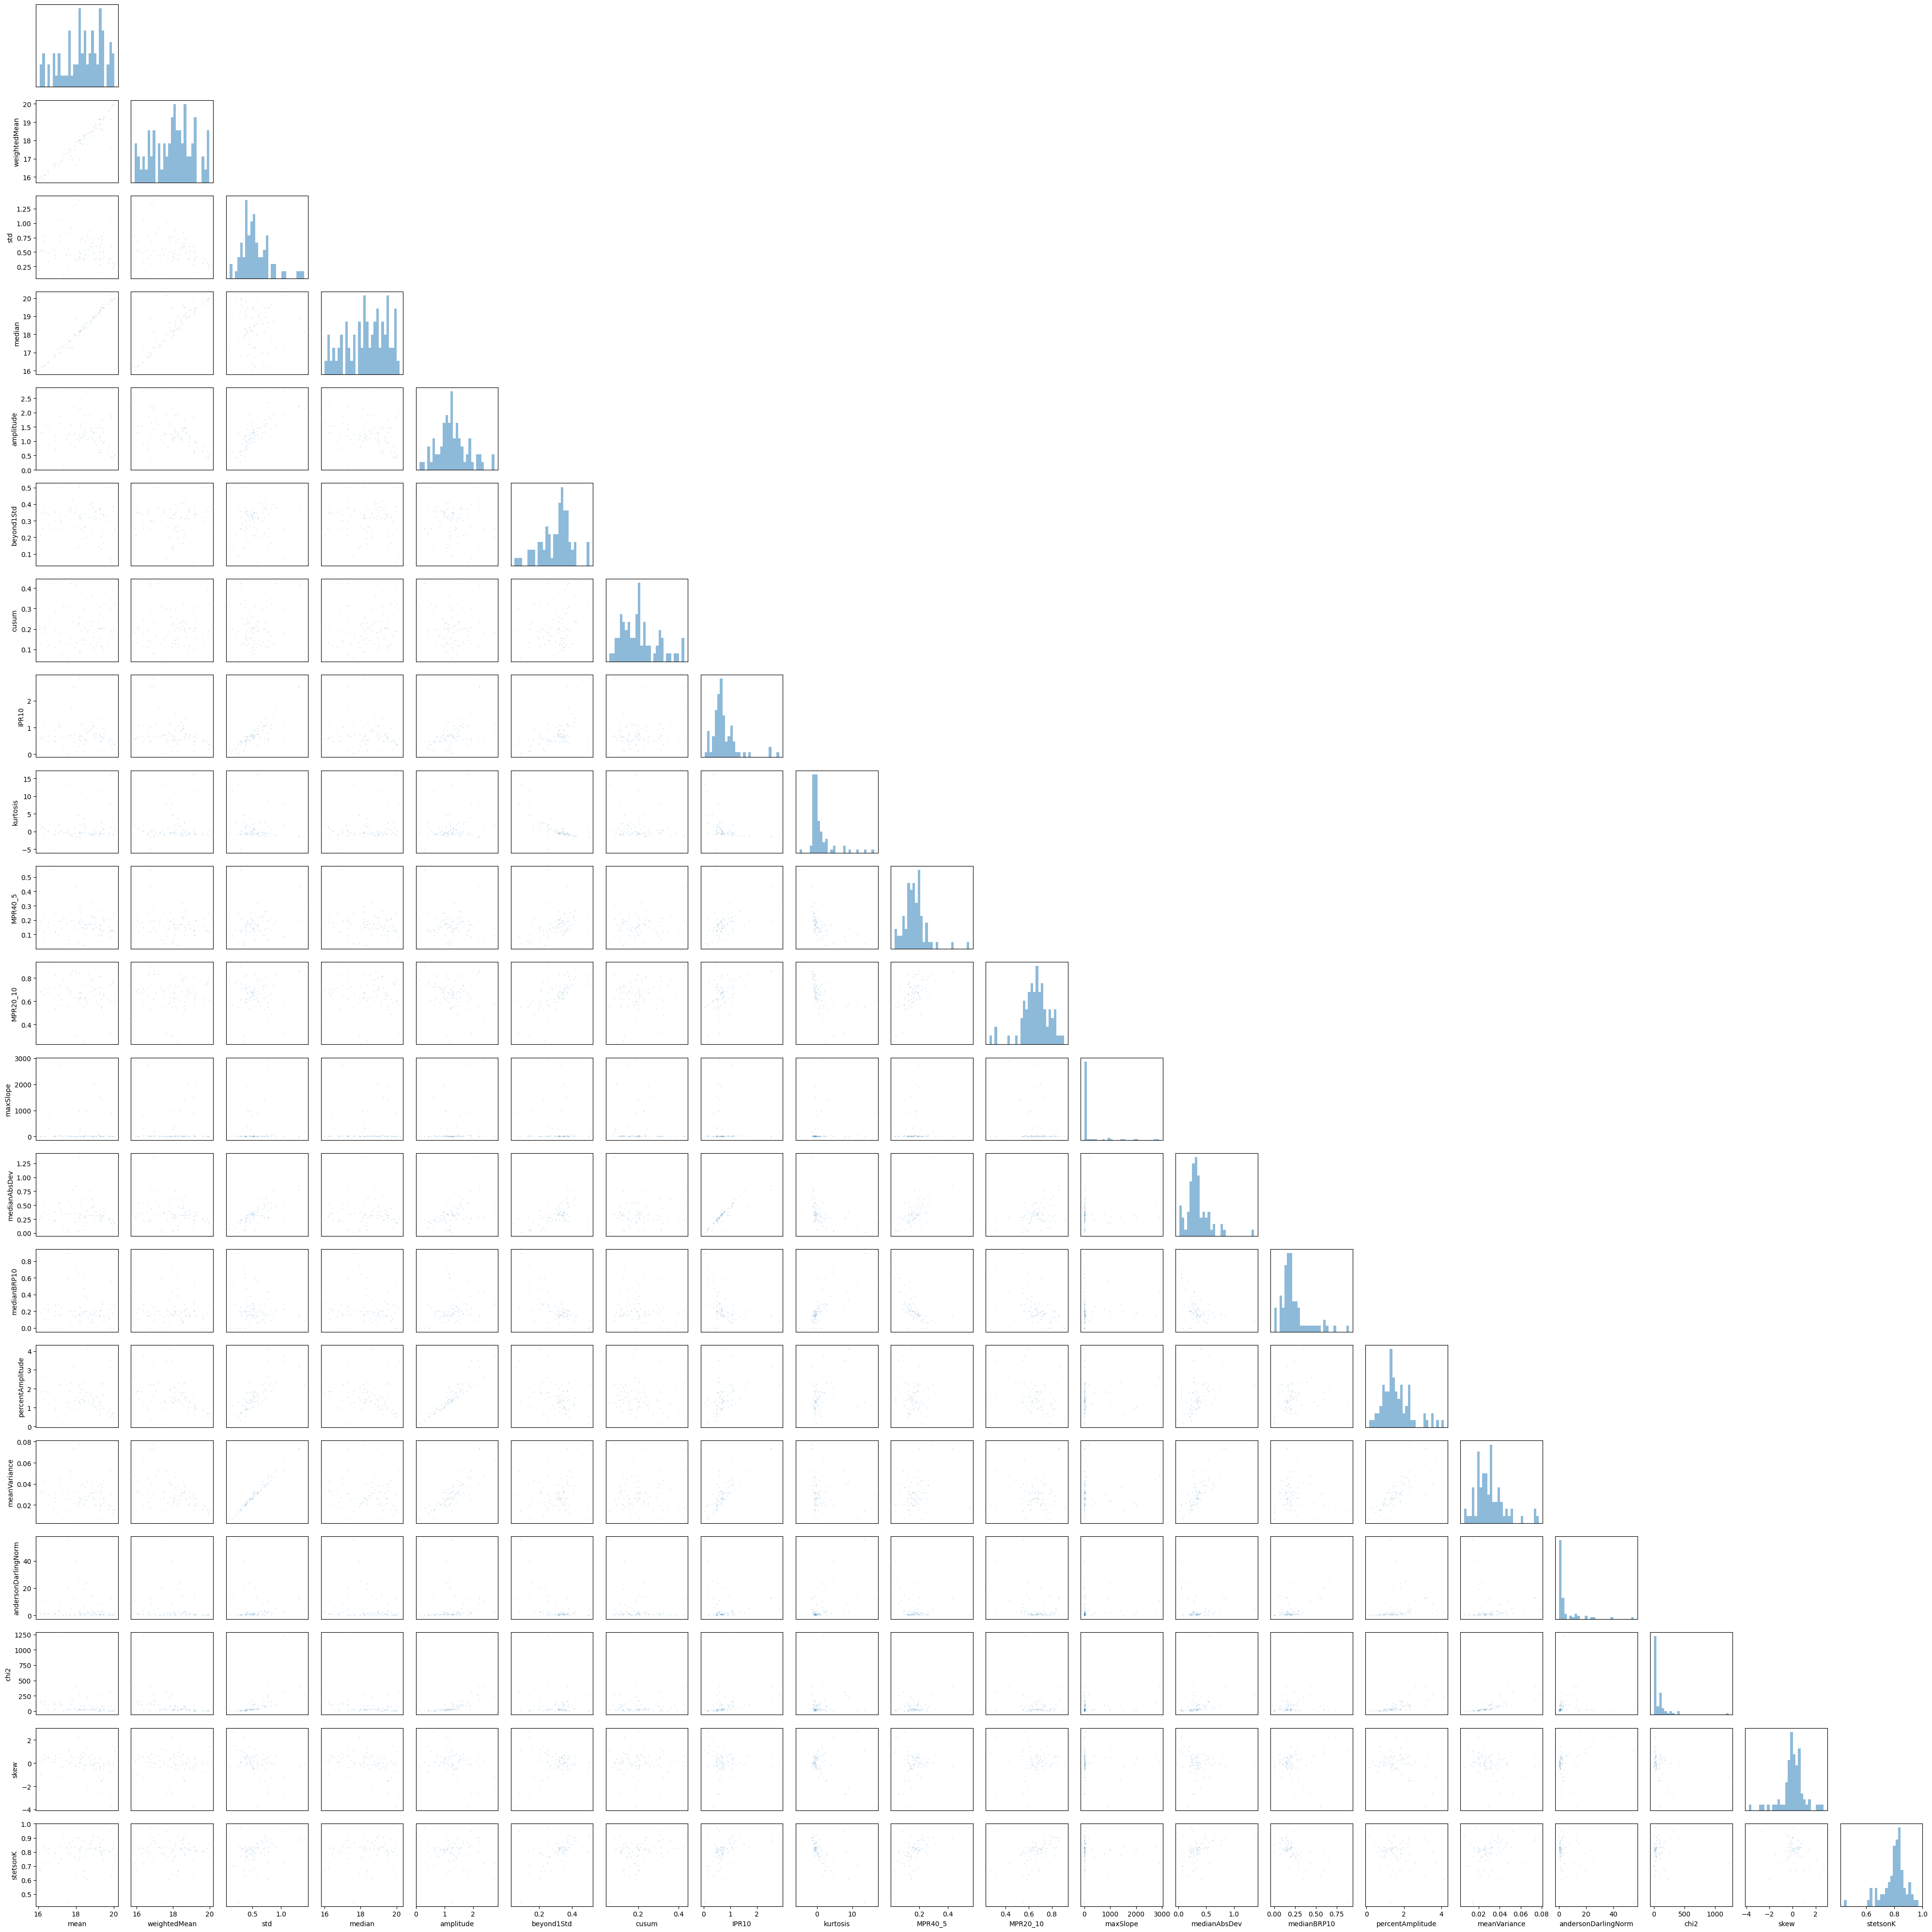

In [8]:
corner_plot(positive_g[feature_names]) # Should take less than a minute to run

## Extracting features from negative class objects

In [9]:
path_to_other_data = '../../data/lc_features_not_nan_JAN2024/' # <----- To be changed accordingly
negative_data = pd.read_parquet(path_to_other_data)

In [10]:
# Removing potential positive class objects from the negative class:
negative_Ids = set(negative_data['objectId']) # Sets remove duplicates
negative_Ids -= negative_Ids.intersection(positive_Ids)

In [11]:
# Sampling Ids from the negative class because the api is not made for large data transfer:
np.random.seed(42)
negative_Ids1 = np.random.choice(list(negative_Ids), len(positive_g), replace=False)

In [12]:
# Initializing the two dataframes which will contain the feature data from the positive class in g and r filter:
negative_g = pd.DataFrame(columns=['objectId', 'time_range (yr)', 'nb_of_points', *feature_names])
negative_r = pd.DataFrame(columns=['objectId', 'time_range (yr)', 'nb_of_points', *feature_names])

# Computing and appending the feature data from each object one at a time:
for object in tqdm2(negative_Ids1):
      # Getting the data from the current object with fink api:
      pdf = pd.read_json(io.BytesIO(requests.post("https://api.fink-portal.org/api/v1/objects",
                                                  json={"objectId": object,
                                                        "columns": "i:objectId,i:jd,i:magpsf,i:sigmapsf,i:fid",
                                                        "output-format": "json"
                                                        }
                                                  ).content
                                    )
                         ).sort_values(by='i:jd') # Sorting by ascending julian date for the extractor. (Output is descending)
      
      # g filter:
      pdf_g = pdf[pdf['i:fid'] == 1]
      t_g = pdf_g['i:jd'].values
      m_g = pdf_g['i:magpsf'].values
      m_err_g = pdf_g['i:sigmapsf'].values
      if len(t_g) >= 4: # Extractor does not accept less than 4 data points.
            result_g = extractor(t_g, m_g, m_err_g, sorted=True, check=False)
            new_row = pd.DataFrame([dict(zip(negative_g.columns, [object, round((max(t_g)-min(t_g))/365, 1), len(t_g), *result_g]))])
            negative_g = pd.concat([negative_g, new_row], ignore_index=True)

      # r filter:
      pdf_r = pdf[pdf['i:fid'] == 2]
      t_r = pdf_r['i:jd'].values
      m_r = pdf_r['i:magpsf'].values
      m_err_r = pdf_r['i:sigmapsf'].values
      if len(t_r) >= 4:
            result_r = extractor(t_r, m_r, m_err_r, sorted=True, check=False)
            new_row = pd.DataFrame([dict(zip(negative_r.columns, [object, round((max(t_r)-min(t_r))/365, 1), len(t_r), *result_r]))])
            negative_r = pd.concat([negative_r, new_row], ignore_index=True)

100%|██████████| 78/78


In [13]:
negative_g

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18abchsjr,5.3,122,19.370210,19.330176,0.227915,19.360979,0.594137,0.344262,0.194273,...,0.000035,0.219692,-0.000102,0.000025,1.729696,0.208234,0.723367,109.581333,0.165588,0.155738
1,ZTF18acwwbfr,4.3,20,19.573969,19.551128,0.237135,19.556648,0.431416,0.300000,0.342111,...,0.000087,0.221881,-0.000179,0.000062,1.575471,0.197448,0.600452,0.076826,0.139219,0.150000
2,ZTF18aczrcbp,5.0,19,19.362384,19.008872,0.517119,19.390785,0.742960,0.421053,0.181088,...,0.000219,0.527963,-0.000089,0.000054,14.760138,0.190047,0.924829,0.247467,0.465601,0.210526
3,ZTF18abcqzrb,5.2,82,16.627581,16.544801,0.307947,16.622352,1.113668,0.195122,0.117341,...,0.000055,0.308720,-0.000006,0.000008,33.547247,0.140902,0.677382,47.520681,0.173750,0.365854
4,ZTF19aaalegu,5.3,45,15.228415,14.918352,0.783128,14.996913,1.350648,0.444444,0.330810,...,0.000186,0.671457,0.000673,0.000012,170.975486,0.219532,0.856718,199.490207,0.565417,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,ZTF20abbzjcq,4.8,37,18.887317,18.733051,0.390570,18.957487,0.708561,0.405405,0.231936,...,0.000112,0.374591,-0.000157,0.000038,8.129984,0.167105,0.737313,0.812883,0.350424,0.135135
63,ZTF18abyxwuu,5.1,15,18.296672,17.736829,0.702681,18.743992,0.798226,0.466667,0.192544,...,0.000303,0.728655,0.000052,0.000041,48.655400,0.433802,0.903594,0.681901,0.253458,0.200000
64,ZTF18acwvijc,2.3,10,19.350524,19.311580,0.247052,19.320081,0.403484,0.300000,0.296265,...,0.000238,0.257733,0.000106,0.000149,2.512323,0.168165,0.624537,0.029181,0.218672,0.300000
65,ZTF18acwwawu,5.3,97,16.366158,16.258623,0.325641,16.343160,0.835146,0.257732,0.091748,...,0.000054,0.327182,-0.000024,0.000009,35.443857,0.094928,0.537048,0.746230,0.179425,0.319588


In [14]:
negative_r

,objectId,time_range (yr),nb_of_points,mean,weightedMean,std,median,amplitude,beyond1Std,cusum,...,MPR20_10,maxSlope,medianAbsDev,medianBRP10,percentAmplitude,meanVariance,andersonDarlingNorm,chi2,skew,stetsonK
0,ZTF18abchsjr,5.3,162,18.888851,18.813105,0.273804,18.864438,0.732511,0.296296,0.090645,...,0.000035,0.274641,0.000054,0.000017,3.650783,0.174846,0.670867,1308.277300,0.195315,0.203704
1,ZTF18acwwbfr,5.1,49,19.014084,18.923267,0.266557,19.042036,0.560199,0.326531,0.341267,...,0.000052,0.207757,-0.000332,0.000034,2.078924,0.206454,0.683253,0.201404,0.196352,0.122449
2,ZTF18aczrcbp,5.1,22,18.527086,18.344265,0.425064,18.484879,0.642829,0.454545,0.284380,...,0.000148,0.410889,0.000202,0.000034,13.895162,0.141174,0.887667,0.470966,0.379558,0.136364
3,ZTF18abcqzrb,4.6,109,16.102526,15.906129,0.323488,16.027370,0.830589,0.311927,0.144358,...,0.000061,0.323425,-0.000082,0.000007,42.174514,0.183155,0.679461,230.885140,0.211688,0.183486
4,ZTF22abuiqqw,1.1,7,18.594918,18.614800,0.191033,18.581589,0.274522,0.142857,0.319000,...,0.000481,0.195720,-0.000139,0.000278,2.553205,0.218933,0.547585,0.012774,0.135734,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,ZTF20abbzjcq,3.2,38,18.694766,18.672680,0.256106,18.654946,0.542418,0.263158,0.189695,...,0.000112,0.242307,-0.000247,0.000061,2.793011,0.175035,0.702203,4.081337,0.185775,0.131579
65,ZTF18abyxwuu,5.1,27,17.729733,17.318903,0.642217,17.809540,1.092961,0.407407,0.225861,...,0.000196,0.652880,0.000007,0.000025,48.530227,0.160234,0.823518,86.037786,0.460758,0.111111
66,ZTF18acwvijc,2.8,5,18.698617,18.609031,0.439533,18.452679,0.509429,0.200000,0.423187,...,0.000606,0.500732,0.000106,0.000160,11.635587,0.292116,0.792116,0.002579,0.186575,0.400000
67,ZTF18acwwawu,5.2,78,16.204354,15.909837,0.448416,16.283380,1.088298,0.230769,0.113980,...,0.000093,0.449036,-0.000287,0.000012,83.877235,0.094356,0.509482,0.586133,0.211997,0.243590
